###Setup

In [ ]:
!pip install -qq tensorflow-text
!pip install -qq transformers
!pip install -qq datasets

     |████████████████████████████████| 4.9 MB 5.4 MB/s 
     |████████████████████████████████| 3.4 MB 5.4 MB/s 
     |████████████████████████████████| 61 kB 426 kB/s 
     |████████████████████████████████| 895 kB 43.5 MB/s 
     |████████████████████████████████| 596 kB 41.0 MB/s 
     |████████████████████████████████| 3.3 MB 9.3 MB/s 
     |████████████████████████████████| 298 kB 5.4 MB/s 
     |████████████████████████████████| 132 kB 45.1 MB/s 
     |████████████████████████████████| 243 kB 38.9 MB/s 
     |████████████████████████████████| 1.1 MB 34.6 MB/s 
     |████████████████████████████████| 160 kB 59.4 MB/s 
     |████████████████████████████████| 192 kB 59.5 MB/s 
     |████████████████████████████████| 271 kB 56.1 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow_text
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import AdamWeightDecay
from tensorflow.keras.utils import to_categorical

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Loading Dataset

In [ ]:
dataset = load_dataset("emotion", cache_dir='/content/drive/MyDrive/datasets/twitter_emotions')

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

Using custom data configuration default
Reusing dataset emotion (/content/drive/MyDrive/datasets/twitter_emotions/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
train_df = pd.DataFrame.from_dict(dataset['train'])
valid_df = pd.DataFrame.from_dict(dataset['validation'])
test_df = pd.DataFrame.from_dict(dataset['test'])

###Model Building

In [ ]:
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3, Total size: 1.96MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1, Total size: 115.55MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'.


In [ ]:
def build_classifier(num_classes):
    text_input = tf.keras.layers.Input(shape=() ,dtype=tf.string ,name='Text_Input_Layer')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name = 'Preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable = True, name = 'BERT_encoder')
    outputs = encoder(encoder_inputs)
    net =  outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(num_classes, activation = 'softmax', name='Classification_Layer')(net)

    return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier(6)

In [ ]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Text_Input_Layer (InputLayer)  [(None,)]            0           []                               
                                                                                                  
 Preprocessing (KerasLayer)     {'input_word_ids':   0           ['Text_Input_Layer[0][0]']       
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [ ]:
epochs = 5
batch_size= 32

optimizer = AdamWeightDecay(
    learning_rate=3e-5,
    weight_decay_rate=0.01
)

In [ ]:
classifier_model.compile(
    optimizer=optimizer, 
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()])

###Training

In [ ]:
history = classifier_model.fit(
    x=np.array(train_df['text'].values),
    y=np.array(to_categorical(train_df['label'].values)),
    validation_data=(
        np.array(valid_df['text'].values),
        np.array(to_categorical(valid_df['label'].values)),
    ),
    epochs=epochs, 
    batch_size=batch_size
)

Training BERT base model
Epoch 1/5
500/500 [==============================] - 218s 418ms/step - loss: 0.9228 - categorical_accuracy: 0.6737 - val_loss: 0.2667 - val_categorical_accuracy: 0.9080
Epoch 2/5
500/500 [==============================] - 205s 410ms/step - loss: 0.2615 - categorical_accuracy: 0.9063 - val_loss: 0.1856 - val_categorical_accuracy: 0.9260
Epoch 3/5
500/500 [==============================] - 205s 411ms/step - loss: 0.1691 - categorical_accuracy: 0.9359 - val_loss: 0.1686 - val_categorical_accuracy: 0.9320
Epoch 4/5
500/500 [==============================] - 205s 410ms/step - loss: 0.1393 - categorical_accuracy: 0.9428 - val_loss: 0.1659 - val_categorical_accuracy: 0.9305
Epoch 5/5
500/500 [==============================] - 205s 411ms/step - loss: 0.1144 - categorical_accuracy: 0.9516 - val_loss: 0.1752 - val_categorical_accuracy: 0.9310


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


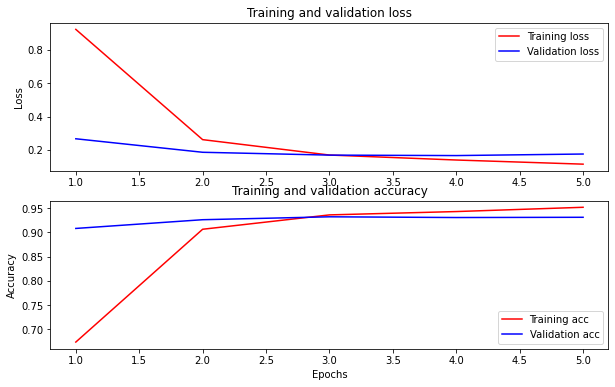

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
classifier_model.save('/content/drive/MyDrive/models/emotion_classifier', include_optimizer=False)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/emotion_classifier/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/emotion_classifier/assets


###Model Evaluation

In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/models/emotion_classifier')

In [ ]:
loaded_model.compile(
    optimizer=optimizer, 
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

In [ ]:
loss, accuracy = loaded_model.evaluate(x=np.array(test_df['text'].values), y=np.array(to_categorical(test_df['label'].values)))
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

63/63 [==============================] - 12s 178ms/step - loss: 0.2023 - categorical_accuracy: 0.9230
Loss: 0.2022876888513565
Accuracy: 0.9229999780654907


###Classification test

In [ ]:
loaded_model.predict(['I love eating sugar!'])

array([[0.00793982, 0.71302676, 0.14600062, 0.1294472 , 0.00076267,
        0.00282298]], dtype=float32)

###Converting Saved Model into TFLite Model format

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('/content/drive/MyDrive/models/emotion_classifier')
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
lite_model = converter.convert()

with open('/content/drive/MyDrive/models/emotion_classifier/model.tflite', 'wb') as f:
  f.write(lite_model)